# Cobra example

This notebook give an example of use of the run_cobra function on the experimental dataset iML1515_EXP_UB. For every row the fluxes given to cobra are zero except the one in the X of the dataset. We also use a constant on to multiply the constraints in attempt to optimize the prediction.

In [2]:
import cobra
from amn.model import AMNWtModel

data_dir = "../data"


dataset_file_experimental = "/Dataset/iML1515_EXP_UB.npz"
cobra_model = cobra.io.read_sbml_model(data_dir + "/Dataset/iML1515_EXP_UB.xml")
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]

constraint_cst = 2.5

# Get some dataset from a model object.
model_experimental = AMNWtModel(dataset_file=data_dir + dataset_file_experimental, 
                   objective=objective,
                   timestep=4,
                   hidden_dim=50,
                   verbose=True,
                   )

# Non-nul input for the metabolic model.
V_in = model_experimental.X * constraint_cst

number of metabolites:  1080
filtered measurements size:  1


In [7]:
from amn.run_cobra import run_cobra

# Result for the cobra model on every entry of the dataset.
Y_pred = []

for i in range(V_in.shape[0]):
    # Initialize all the reaction to 0.
    inf = {r.id: 0 for r in cobra_model.reactions}
    # Add all the non-nul inputs for the entry i.
    for j in range(V_in.shape[1]):
        inf[model_experimental.medium[j]] = float(V_in[i,j])
    result = run_cobra(cobra_model,objective , inf, method='pFBA')

    Y_pred.append(result[1])


In [14]:
len(cobra_model.reactions)

543

Text(0.5, 1.0, 'R2 = 0.37087583994346995')

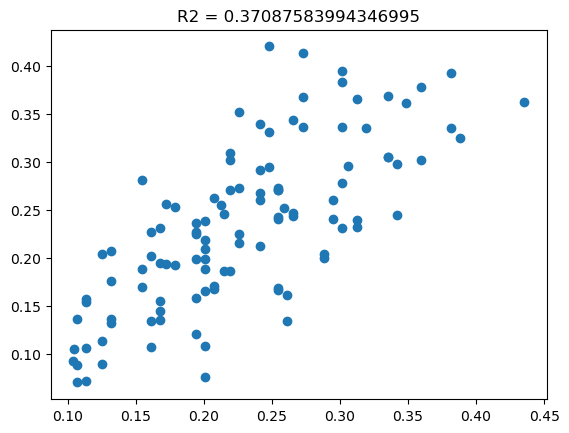

In [7]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


plt.scatter(Y_pred, model_experimental.Y)
plt.title(f"R2 = {r2_score(Y_pred, model_experimental.Y)}")

In [ ]:
def run_cobra(model, objective, IN, method='FBA', verbose=False,
              objective_fraction=0.75, cobra_min_flux=1.0e-8):
    # Inputs:
    # - model
    # - objective: a list of reactions (only the two first are considered)
    # - IN: Initial values for all reaction fluxes
    # - method: FBA or pFBA
    # run FBA optimization to compute reaction fluxes on the provided model
    # set the medium using values in dictionary IN.
    # When 2 objectives are given one first maximize the first objective (obj1).
    # then one set the upper and lower bounds for that objective to
    # objective_fraction * obj1 (e.g. objective_fraction = 0.75) and maximize
    # for the second objective
    # Outputs:
    # - FLUX, the reaction fluxes computed by FBA for all reactions
    # - The value for the objective

    # set the medium and objective
    medium = model.medium


    # print(type(model))

    # fix solver timeout
    model.solver.configuration = optlang.glpk_interface.Configuration(timeout=5, presolve='auto', lp_method='simplex')


    medini = medium.copy()

    for k in medium.keys(): # Reset the medium
        medium[k] = 0
    for k in IN.keys(): # Additional cmpds added to medium
        if k in medium.keys():
            medium[k] = float(IN[k])

    
    model.medium = medium

    # run FBA for primal objective
    model.objective = objective[0] 
    solution = cobra.flux_analysis.pfba(model) if method == 'pFBA' else model.optimize()
    solution_val = solution.fluxes[objective[0]]
    if verbose:
        print('primal objectif =', objective, method, solution_val)

    # run FBA for second objective
    # primal objectif is set to a fraction of its value
    if len(objective) > 1:
        obj = model.reactions.get_by_id(objective[0])
        obj_lb, obj_ub = obj.lower_bound, obj.upper_bound
        obj.lower_bound = objective_fraction * solution_val
        obj.upper_bound = objective_fraction * solution_val
        model.objective = objective[1]
        solution = cobra.flux_analysis.pfba(model) \
        if method == 'pFBA' else model.optimize()
        solution_val = solution.fluxes[objective[1]]
        if verbose:
            print('second objectif =', objective, method, solution_val)

        # reset bounds and objective to intial values
        obj.lower_bound, obj.upper_bound = obj_lb, obj_ub
        model.objective = objective[0]

    # get the fluxes for all model reactio
    FLUX = IN.copy()
    for x in model.reactions:
        if x.id in FLUX.keys():
            FLUX[x.id] = solution.fluxes[x.id]
            if math.fabs(float(FLUX[x.id])) < cobra_min_flux: # !!! if smaller than a min level, return 0 ???
                FLUX[x.id] = 0

    # Reset medium
    model.medium = medini


    return FLUX, solution_val

In [ ]:
from library.parallel import *


def fit_cobra(cobramodel, objective, i, IN, method='FBA', gene = [], genename = [], verbose=False):
    """
    Fit a COBRA model with A SINGLE data point.

    Parameters:
    - i (int): position in data array.

    Returns:
    - y_cobra (float or None): The optimized value of the specified objective function
    - rows_with_warnings (list): A list containing indices of rows where warnings were generated during optimization.
    """
    rows_with_warnings = []

    with warnings.catch_warnings(record=True) as w, cobramodel:
        cobramodel = set_medium(cobramodel,IN, exact = False)
        if len(gene) > 0:
            cobramodel = knock_out(cobramodel,i,gene,genename, rebound = True, esp = 0)
        solution = cobra.flux_analysis.pfba(cobramodel) if method == 'pFBA' else cobramodel.optimize()
        y_cobra = solution.fluxes[objective]

        #get all fluxes after reactions, TO DOs: also set to bound 0
        for key, _ in IN.items():
            IN[key] = solution.fluxes[key]

        if w:
            rows_with_warnings.append(i)
        if verbose:
            print('objectif =', objective, method, y_cobra)
    
    return IN, y_cobra, rows_with_warnings

In [ ]:

medium = dict(zip(model_experimental.medium, medium_X[i,:]))
